In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import numpy as np
import sklearn
import pandas as pd
import os
from numpy.linalg import inv, svd
import matplotlib.pyplot as plt 
from itertools import combinations
from sklearn import linear_model as lm
import cvxpy as cp
import seaborn as sns
import warnings

from joshiboyd import *
warnings.filterwarnings('ignore')

### Things that we want to do:

(1) For the entire dataset, see what the rank of the matrix is and compare it to a **shuffled matrix**

(2) Check correlations between predicted and true concept and color ratings **with no holdout** as a function of number of components chosen

(3) Check correlations between predicted and true concept and color ratings **with each concept and color held out** for the decided number of components\\

From (2) we should get 2 things. The first is the number of components, which can see by inspecting the confidence intervals, where variability comes from the individual concepts and colors.\\
The second is the effect of varying the number of colors we use to estimate held out concepts. The way we get the colors and concepts is by picking based on Laurent's Joshi Boyd method or by visual inspection

In [63]:
for i in range(1,59):
    A = pd.read_csv('../../data/basis_vecs_scaled_color_{}.csv'.format(i))
    A = np.array(A)
    A = np.delete(A, 0, axis=1) ## deleting column with concept names
    A_8 = A[:,0:8]
    A_8_df = pd.DataFrame(A_8)
    A_8_df.to_csv('../../data/8_basis_vecs_scaled_color_{}.csv'.format(i)) ### save just the first 8 right singular vectors for each color holdout

In [11]:
basis_vecs = pd.read_csv('../../data/basis_vecs_scaled.csv') ### Load singular vectors computed from full dataset
ratings= pd.read_csv('../../data/uw_58_ratings_matrix_unscaled.csv') ### Load ratings matrix
c_means = pd.read_csv('../../data/col_means.csv')  ### Load a vector of column means 

In [12]:
basis_vecs = np.array(basis_vecs)
basis_vecs = np.delete(basis_vecs, 0, axis=1)
#A_8 = A[:,0:8]
#A_8_df = pd.DataFrame(A_8)
#A_8_df.to_csv('../../data/8_basis_vecs_scaled.csv') ### save just the first 8 right singular vectors for full dataset

## Interlude to see how many dims we need

In [13]:
factor_mat = pd.read_csv('../../data/factor_vecs_scaled.csv') ### left singular vectors scaled with singular values
factor_mat = np.array(factor_mat)
factor_mat = np.delete(factor_mat, 0, axis=1)

In [14]:
concept_ratings = ratings.iloc[:,1:59]
concept_ratings = np.array(concept_ratings)

In [15]:
rng = np.random.default_rng()

test = concept_ratings - c_means.V1.values ### true ratings with columns centered
shuffle_test = concept_ratings - c_means.V1.values ### same as above
shuffle_test = rng.permuted(shuffle_test) ### permuted ratings
shuf_u, shuf_s, shuf_vt = svd(shuffle_test, full_matrices=False) ###svd of shuffled matrix
factor_mat_shuf = shuf_u@np.diag(shuf_s) ### left singular vectors scaled with singular values for shuffled matrix


In [16]:
n_comp = []
r =[] ## will hold reconstruction correlations for unshuffled matrix
r_shuf = [] ## will hold reconstruction correlations for shuffled matrix
from scipy.stats.stats import pearsonr 
for i in range(1,30): ### concept
    for j in range(1,30): ### ncomps
        r.append(pearsonr(np.matmul(factor_mat[:,0:j+1],basis_vecs.T[0:j+1,:])[i,],test[i,])[0])
        r_shuf.append(pearsonr(np.matmul(factor_mat_shuf[:,0:j+1],shuf_vt[0:j+1,:])[i,],shuffle_test[i,])[0])
        n_comp.append(j)
        
cor_df = pd.DataFrame({'n_comp':n_comp,'r':r,'r_shuf':r_shuf})


Text(0.5, 1.0, 'Shuffled vs unshuffled reconstructions')

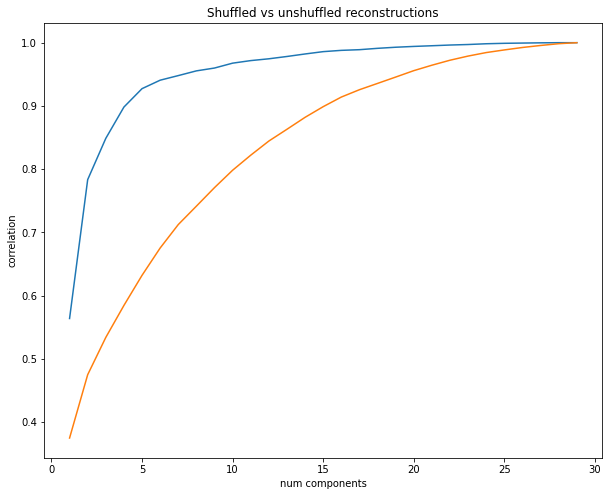

In [17]:
summary_cor_df = cor_df.groupby(n_comp).mean().reset_index()

plt.figure(figsize=(10,8))
plt.plot(np.arange(1,30),summary_cor_df.r)
plt.plot(np.arange(1,30),summary_cor_df.r_shuf)
plt.xlabel('num components')
plt.ylabel('correlation')
plt.title('Shuffled vs unshuffled reconstructions')

### Choosing colors to estimate new concepts

In [150]:

##high low col inds

#color_inds = [4, 22, 23, 26, 29, 32, 53, 56]#CVXOPT 
#color_inds = [3, 4, 8, 22, 23, 24, 26, 53] #SCS
#color_inds=[0, 2, 3, 13, 22, 23, 26, 27, 32, 36, 49, 53, 55, 57] ## * best
#color_inds=[0, 2, 3, 13, 22, 23, 32, 49, 53, 55, 57] ##

#color_inds = [1,  7,  8, 12, 14, 19, 27, 28, 31, 33, 38, 46, 53] ## from R top and bottom
#color_inds = [1,  2,  8, 12, 14, 19, 26, 27, 28, 33, 35, 36, 38, 39, 55] ##top 2
#color_inds = [x - 1 for x in color_inds]


### new as of 2021

color_inds = [4, 21, 22, 23, 24, 26, 32, 38, 49, 50, 53, 54, 56, 57]



## No Holdout reconstructions

We are going to approximate a factor matrix by using linear regression and approximate the right singular vectors matrix using the colorimetric regression. Without any holdout, we are going to observe how the reconstruction correlation increases as a function of # components and what value to use for our correlations\\

As a start use all the colors we have and don't subsample when doing the regressions

In [318]:
### DEPRECATED. Keep around for now

# conc_prof_mat = np.zeros(shape=(30,5)) ## this matrix holds the approximated factor matrix 

# cors = []
# for i in range(ratings.shape[0]): ## iterate through each concept
#     concept_ratings = ratings.iloc[i][1:59]
#     concept_ratings = np.array(concept_ratings)
#     concept_ratings = concept_ratings-c_means.V1.values
#     reg = lm.LinearRegression().fit(A[color_inds,:5], concept_ratings[color_inds])
#     #reg = lm.LinearRegression().fit(A_8, concept_ratings)
#     coords = reg.coef_[0:5]   ## only use 5 components
#     recon = np.matmul(A[:,:5],coords)
#     cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
#     conc_prof_mat[i,:] = coords
               

In [18]:
num_pcs =[]
approx_cors = [] ## hold correlations for reconstructions
cons = []
for num_pc in range(1,10):
    conc_prof_mat = np.zeros(shape=(30,num_pc)) ## this matrix holds the approximated factor matrix 
 
    for i in range(ratings.shape[0]): ## iterate through each concept

        concept_ratings = ratings.iloc[i][1:59]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-c_means.V1.values
        #reg = lm.LinearRegression().fit(A[color_inds,0:num_pc], concept_ratings[color_inds])
        reg = lm.LinearRegression().fit(basis_vecs[:,0:num_pc], concept_ratings)
        coords = reg.coef_[0:num_pc]   ## only use num_pc components
        # recon = np.matmul(A[:,:num_pc],coords)
        # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
        conc_prof_mat[i,:] = coords
        

    ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
    prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:num_pc] ## weights to approximate first num_pc coordinates of the right singular vectors
    approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

   
    for i in range(approx_recon.shape[0]):
        concept_ratings = ratings.iloc[i][1:59]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-c_means.V1.values
        approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
        num_pcs.append(num_pc)
        cons.append(ratings.iloc[i][0])


approx_df = pd.DataFrame(list(zip(cons,num_pcs,approx_cors)), columns = ['concept','num_pcs','correlation'])

In [19]:
approx_df.groupby('num_pcs').mean().reset_index() 

### Looks like around 5 pcs is what we'll want

,num_pcs,correlation
0,1,0.352488
1,2,0.572271
2,3,0.741791
3,4,0.788196
4,5,0.834641
5,6,0.841193
6,7,0.843925
7,8,0.843937
8,9,0.844020


Text(0, 0.5, 'correlation')

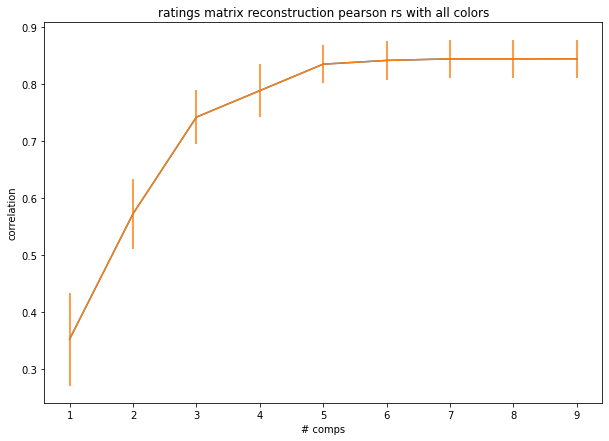

In [20]:
plot_ys = approx_df.groupby('num_pcs').mean().reset_index().correlation
plot_err = approx_df.groupby('num_pcs').std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(1,10),plot_ys)
plt.errorbar(x= np.arange(1,10),y = plot_ys,yerr=plot_err)
plt.title('ratings matrix reconstruction pearson rs with all colors')
plt.xlabel('# comps')
plt.ylabel('correlation')

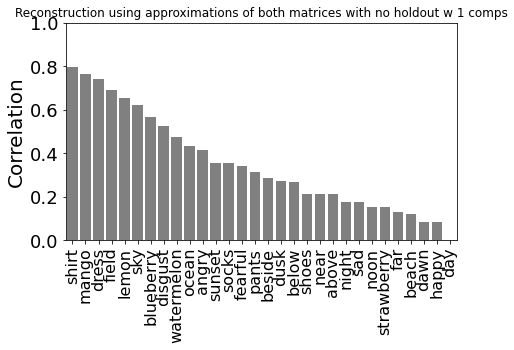

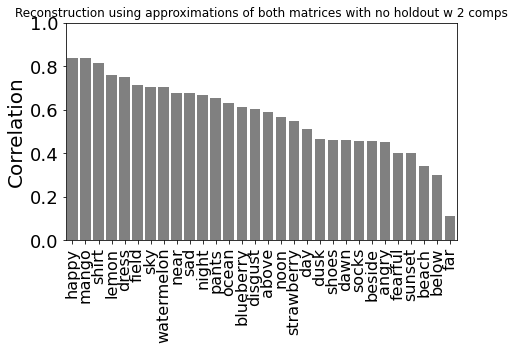

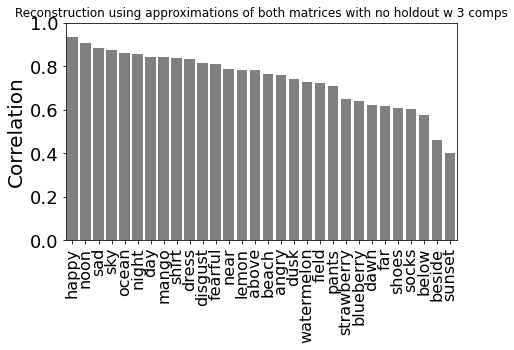

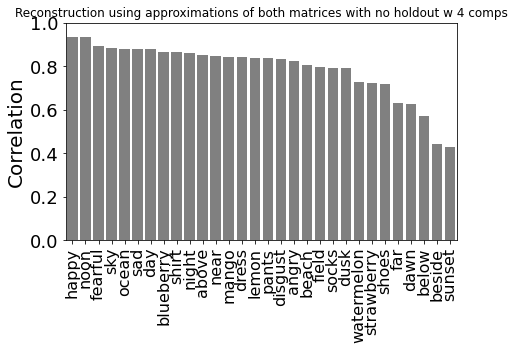

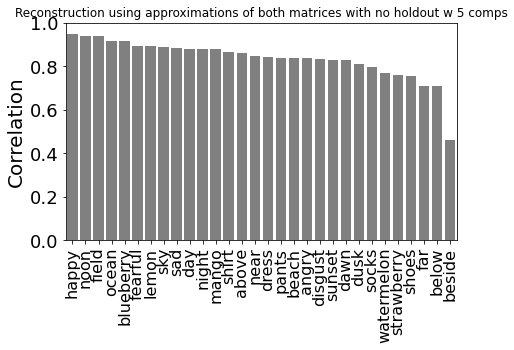

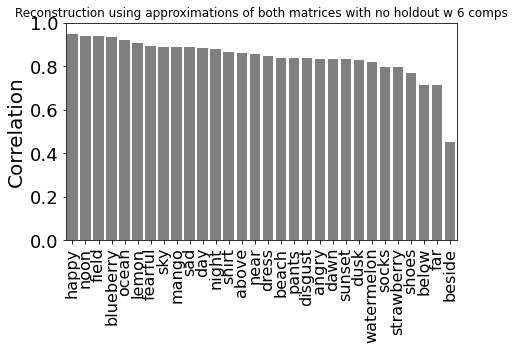

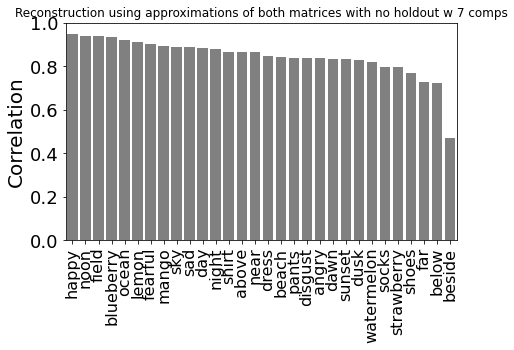

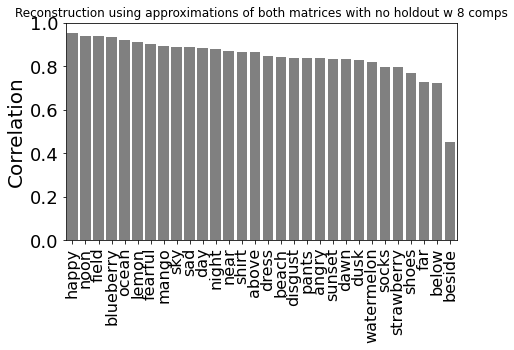

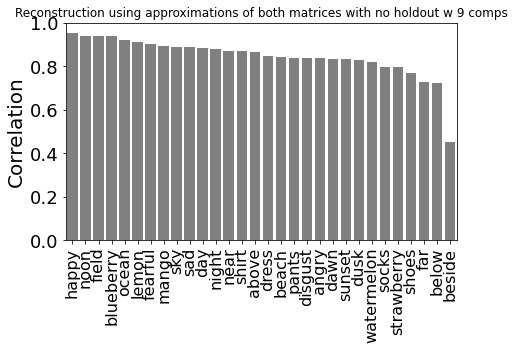

In [176]:
## See how the patterns of reconstruction change for the concepts

for i in range(1,10):

    approx_df_sub = approx_df[approx_df.num_pcs==i].sort_values(['correlation'],ascending=False).reset_index(drop=True)
    fig = plt.figure(figsize=(7,4))
    sns.barplot(approx_df_sub.concept, approx_df_sub.correlation, edgecolor = 'none', color='gray')
    #plt.axis('off')
    #plt.xticks([])
    plt.xticks(rotation = 90, fontsize= 16)
    plt.xlabel('')
    plt.yticks(fontsize=18)
    plt.ylabel('Correlation', fontsize=20)
    plt.ylim(0,1)
    ax = plt.gca()
    #ax.set_facecolor((0.3497,0.3497,0.3497))
    ax.set_facecolor((1,1,1))
    plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} comps")
    # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
    plt.show()

### Effect of varying the subsampled colors

For now we are going with the Joshi-Boyd method of selecting rows with 6 PCs

In [46]:
num_cols =[]
approx_cors = []
cons = []
for num_col in range(2,20,1):
    color_inds = return_rows(ratings.iloc[:,1:]-c_means.V1.values,num_col)
    conc_prof_mat = np.zeros(shape=(30,6)) ## this matrix holds the approximated factor matrix 
 
    for i in range(ratings.shape[0]): ## iterate through each concept
        

        concept_ratings = ratings.iloc[i][1:59]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-c_means.V1.values
        reg = lm.LinearRegression().fit(basis_vecs[color_inds,0:6], concept_ratings[color_inds])
        #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
        coords = reg.coef_[0:6]   ## only use num_pc components
        # recon = np.matmul(A[:,:num_pc],coords)
        # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
        conc_prof_mat[i,:] = coords
        

    ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
    prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors
    approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

   
    for i in range(approx_recon.shape[0]):
        concept_ratings = ratings.iloc[i][1:59]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-c_means.V1.values
        approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
        num_cols.append(num_col)
        cons.append(ratings.iloc[i][0])


approx_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors)), columns = ['concept','num_cols','correlation'])

Text(0, 0.5, 'correlation')

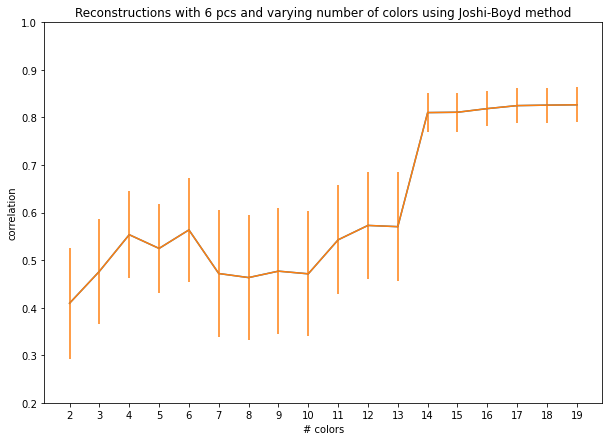

In [47]:
plot_ys = approx_df.groupby('num_cols').mean().reset_index().correlation
plot_err = approx_df.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(2,20,1),plot_ys)
plt.errorbar(x= np.arange(2,20,1),y = plot_ys,yerr=plot_err)
plt.title('Reconstructions with 6 pcs and varying number of colors using Joshi-Boyd method')
plt.xlabel('# colors')
plt.xticks(np.arange(2,20,1))
plt.ylim(.2,1)
plt.ylabel('correlation')

In [48]:
print(plot_ys)


0     0.409323
1     0.476430
2     0.553415
3     0.524556
4     0.563463
5     0.471772
6     0.463256
7     0.476758
8     0.471159
9     0.542633
10    0.572917
11    0.570302
12    0.810155
13    0.810844
14    0.818518
15    0.824812
16    0.825786
17    0.826527
Name: correlation, dtype: float64


In [53]:

random.sample(range(58),2)

[17, 30]

In [65]:
import random 
num_cols =[]
approx_cors = []
cons = []
run = [] ###track which iteration it is

for this_run in range(1000):
    for num_col in range(2,20,1):
        color_inds = random.sample(range(58),num_col)
        conc_prof_mat = np.zeros(shape=(30,6)) ## this matrix holds the approximated factor matrix 
    
        for i in range(ratings.shape[0]): ## iterate through each concept
            

            concept_ratings = ratings.iloc[i][1:59]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-c_means.V1.values
            reg = lm.LinearRegression().fit(basis_vecs[color_inds,0:6], concept_ratings[color_inds])
            #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
            coords = reg.coef_[0:6]   ## only use num_pc components
            # recon = np.matmul(A[:,:num_pc],coords)
            # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
            conc_prof_mat[i,:] = coords
            

        ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
        color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
        prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors
        approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

    
        for i in range(approx_recon.shape[0]):
            concept_ratings = ratings.iloc[i][1:59]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-c_means.V1.values
            approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
            num_cols.append(num_col)
            cons.append(ratings.iloc[i][0])
            run.append(this_run)


approx_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors,run)), columns = ['concept','num_cols','correlation','run'])

In [66]:
approx_df_ = approx_df.groupby(['num_cols','run']).mean().reset_index()

Text(0, 0.5, 'correlation')

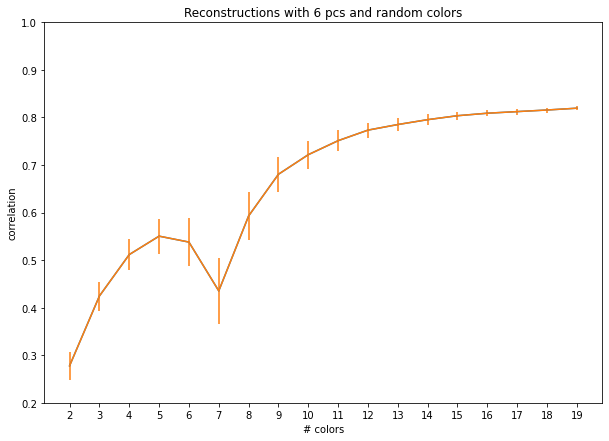

In [64]:

plot_ys = approx_df_.groupby('num_cols').mean().reset_index().correlation
plot_err = approx_df_.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(2,20,1),plot_ys)
plt.errorbar(x= np.arange(2,20,1),y = plot_ys,yerr=plot_err)
plt.title('Reconstructions with 6 pcs and random colors')
plt.xlabel('# colors')
plt.xticks(np.arange(2,20,1))
plt.ylim(.2,1)
plt.ylabel('correlation')

Text(0, 0.5, 'correlation')

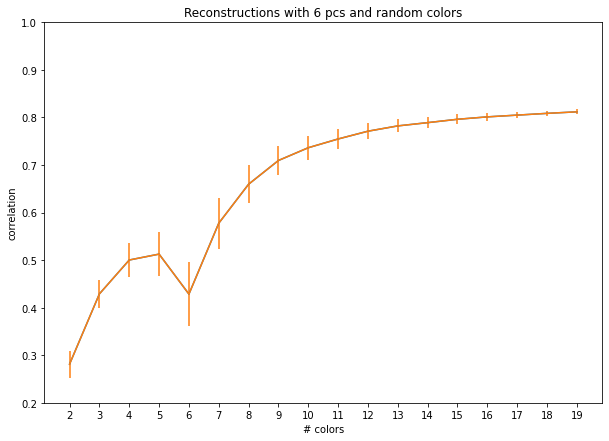

In [67]:

plot_ys = approx_df_.groupby('num_cols').mean().reset_index().correlation
plot_err = approx_df_.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(2,20,1),plot_ys)
plt.errorbar(x= np.arange(2,20,1),y = plot_ys,yerr=plot_err)
plt.title('Reconstructions with 6 pcs and random colors')
plt.xlabel('# colors')
plt.xticks(np.arange(2,20,1))
plt.ylim(.2,1)
plt.ylabel('correlation')

In [63]:
plot_ys

0     0.277742
1     0.424455
2     0.511586
3     0.550361
4     0.537916
5     0.435273
6     0.592789
7     0.680453
8     0.721631
9     0.751079
10    0.773270
11    0.785007
12    0.795268
13    0.803573
14    0.808812
15    0.812210
16    0.815568
17    0.819376
Name: correlation, dtype: float64

In [68]:
plot_ys

0     0.281258
1     0.428930
2     0.500190
3     0.512613
4     0.428501
5     0.577560
6     0.659541
7     0.709425
8     0.736264
9     0.754649
10    0.771019
11    0.782145
12    0.789003
13    0.796077
14    0.801136
15    0.804826
16    0.808509
17    0.811731
Name: correlation, dtype: float64

In [69]:
color_coord_mat

array([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00],
       [ 7.5000e+01,  2.5000e+01,  5.0000e+01,  7.5000e+01,  2.5000e+01,
         5.0000e+01,  7.5000e+01,  2.5000e+01,  5.0000e+01,  5.0000e+01,
   

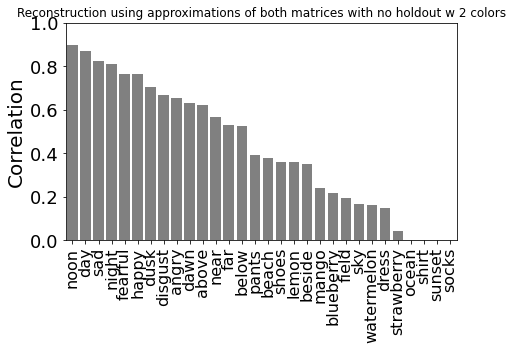

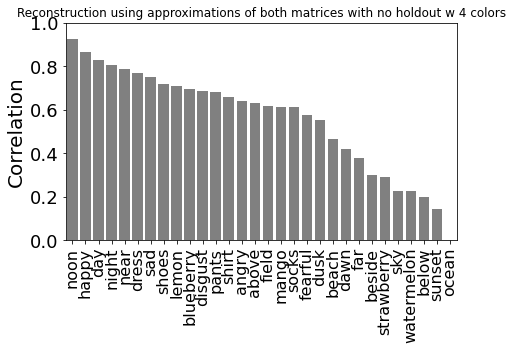

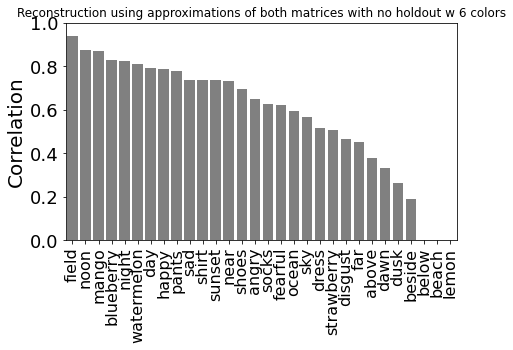

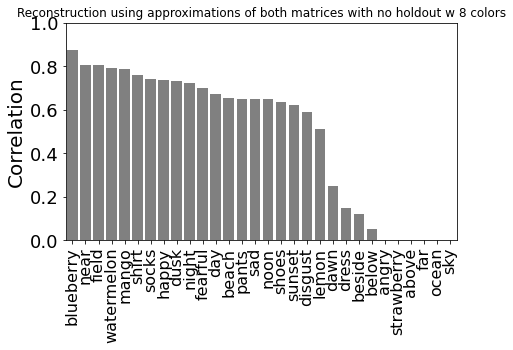

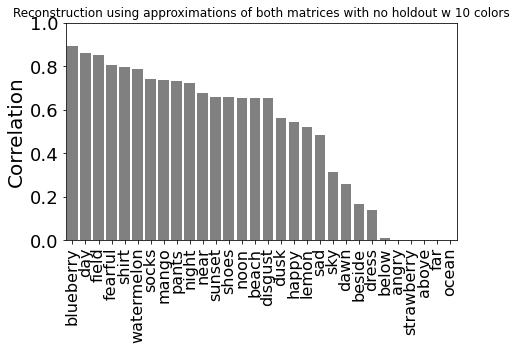

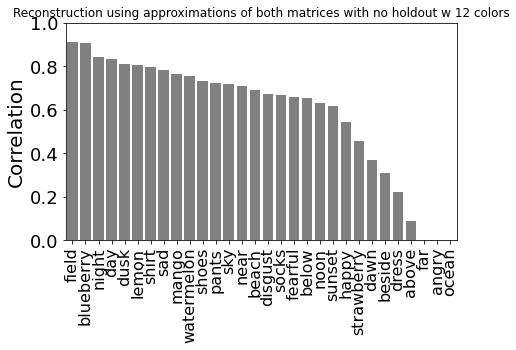

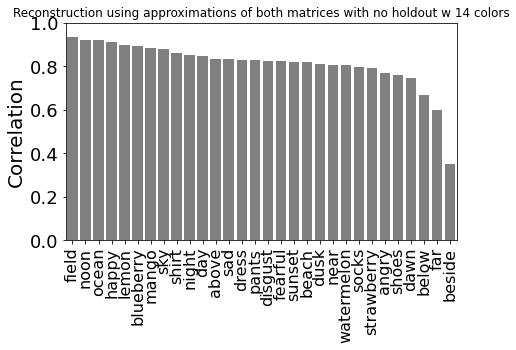

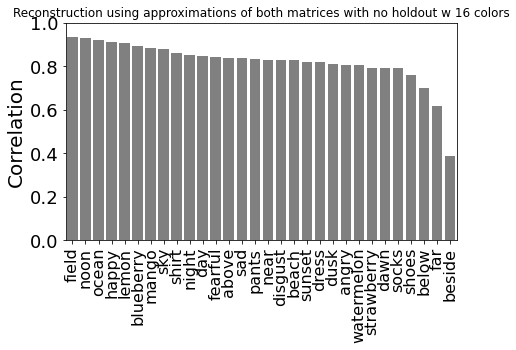

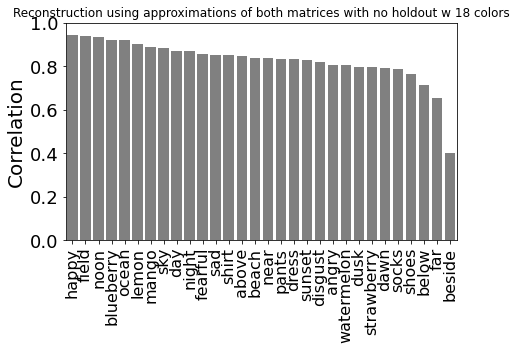

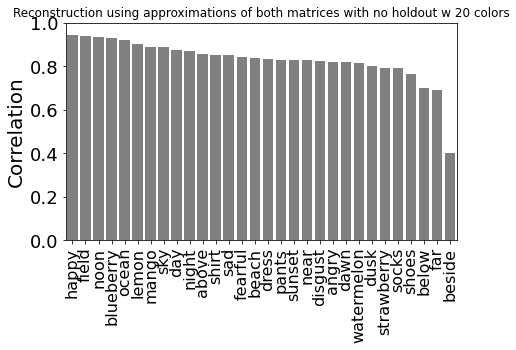

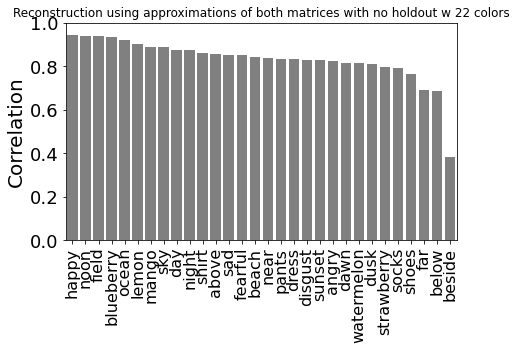

In [291]:
## See how the patterns of reconstruction change for the concepts

for i in range(2,24,2):

    approx_df_sub = approx_df[approx_df.num_cols==i].sort_values(['correlation'],ascending=False).reset_index(drop=True)
    fig = plt.figure(figsize=(7,4))
    sns.barplot(approx_df_sub.concept, approx_df_sub.correlation, edgecolor = 'none', color='gray')
    #plt.axis('off')
    #plt.xticks([])
    plt.xticks(rotation = 90, fontsize= 16)
    plt.xlabel('')
    plt.yticks(fontsize=18)
    plt.ylabel('Correlation', fontsize=20)
    plt.ylim(0,1)
    ax = plt.gca()
    #ax.set_facecolor((0.3497,0.3497,0.3497))
    ax.set_facecolor((1,1,1))
    plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} colors")
    # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
    plt.show()

In [292]:
ratings_arr = np.array(pd.read_csv('../../data/uw_58_ratings_matrix_unscaled.csv'))[:,1:]
ratings_arr = ratings_arr.astype('float')
assoc_mat_c = ratings_arr- c_means.V1.values
U,S,Vh = svd(assoc_mat_c, full_matrices=False)

In [293]:
U_6 = U[:,0:6]
U_6.shape



(30, 6)

In [294]:
assoc_mat_c.shape

(30, 58)

In [295]:
color_comp_cors = np.zeros((6,58))
for i in range(U_6.shape[1]):
    for j in range(assoc_mat_c.shape[1]):
        color_comp_cors[i,j] = np.corrcoef(U_6[:,i],assoc_mat_c[:,j])[0][1]


In [296]:

def maxmin_colors(num_per_comp,color_comp_cors=color_comp_cors):
    hi_cols = np.argsort(-color_comp_cors[:,:],axis=1)[:,:num_per_comp]
    lo_cols = np.argsort(color_comp_cors[:,:],axis=1)[:,:num_per_comp]

    colors = np.unique(np.hstack([hi_cols,lo_cols]).flatten())
    print(colors.shape)
    return list(colors)



In [297]:
maxmin_colors(1)

(11,)


[0, 1, 6, 13, 32, 38, 39, 48, 51, 53, 54]

In [324]:
num_cols =[]
approx_cors = []
cons = []
for num_col in range(1,6):
    color_inds = maxmin_colors(num_col)
    conc_prof_mat = np.zeros(shape=(30,6)) ## this matrix holds the approximated factor matrix 
 
    for i in range(ratings.shape[0]): ## iterate through each concept
        

        concept_ratings = ratings.iloc[i][1:59]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-c_means.V1.values
        reg = lm.LinearRegression().fit(A[color_inds,0:6], concept_ratings[color_inds])
        #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
        coords = reg.coef_[0:6]   ## only use num_pc components
        # recon = np.matmul(A[:,:num_pc],coords)
        # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
        conc_prof_mat[i,:] = coords
        

    ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
    prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors
    approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

   
    for i in range(approx_recon.shape[0]):
        concept_ratings = ratings.iloc[i][1:59]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-c_means.V1.values
        approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
        num_cols.append(len(color_inds))
        cons.append(ratings.iloc[i][0])


approx_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors)), columns = ['concept','num_cols','correlation'])

(11,)
(22,)
(31,)
(39,)
(47,)


In [325]:
approx_df.num_cols.unique()

array([11, 22, 31, 39, 47])

Text(0, 0.5, 'correlation')

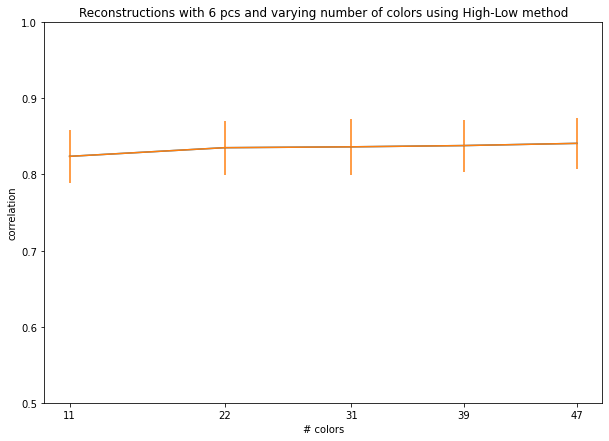

In [326]:
plot_ys = approx_df.groupby('num_cols').mean().reset_index().correlation
plot_err = approx_df.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(approx_df.num_cols.unique(),plot_ys)
plt.errorbar(x= approx_df.num_cols.unique(),y = plot_ys,yerr=plot_err)
plt.title('Reconstructions with 6 pcs and varying number of colors using High-Low method')
plt.xlabel('# colors')
plt.xticks(approx_df.num_cols.unique())
plt.ylim(.5,1)
plt.ylabel('correlation')

In [301]:
print(plot_ys)

0    0.823851
1    0.835218
2    0.836353
3    0.838015
4    0.840902
Name: correlation, dtype: float64


In [315]:
uw58rgb

,0,1,2
0,0.302940,0.780570,0.909830
1,0.110780,0.237980,0.380060
2,0.366760,0.471510,0.631640
3,0.627550,0.729060,0.902710
4,0.315710,0.175330,0.374010
5,0.565830,0.408700,0.625220
6,0.834930,0.664230,0.895970
7,0.448440,0.001016,0.368560
8,0.720680,0.315080,0.619280
9,0.857950,0.120840,0.613890


In [162]:
uw58rgb = pd.read_csv('../../data/UW_58_rgb.csv', header=None)
uw58rgb_tups= np.array(uw58rgb.apply(lambda x: tuple(x),axis=1))

In [163]:
sns.color_palette(uw58rgb_tups)

[(0.30294, 0.78057, 0.90983),
 (0.11078, 0.23798, 0.38006),
 (0.36676, 0.47151, 0.63164),
 (0.62755, 0.72906, 0.90271),
 (0.31571, 0.17533, 0.37401),
 (0.56583, 0.4087, 0.62522),
 (0.83493, 0.66423, 0.89597),
 (0.44844, 0.0010157, 0.36856),
 (0.72068, 0.31508, 0.61928),
 (0.85795, 0.12084, 0.61389),
 (0.02815, 0.47995, 0.80007),
 (0.17927, 0.18835, 0.5261),
 (0.45531, 0.41794, 0.79284),
 (0.37742, 0.042633, 0.5195),
 (0.64719, 0.32647, 0.78598),
 (0.80294, 0.14735, 0.7795),
 (0.18536, 0.43139, 0.96497),
 (0.20878, 0.093277, 0.67755),
 (0.52107, 0.34328, 0.95741),
 (0.71554, 0.18209, 0.95015),
 (0.23228, 0.51203, 0.47224),
 (0.49553, 0.7754, 0.73022),
 (0.0, 0.0, 0.0),
 (0.23251, 0.23251, 0.23251),
 (0.46633, 0.46633, 0.46633),
 (0.7239, 0.7239, 0.7239),
 (1.0, 1.0, 1.0),
 (0.36814, 0.16901, 0.22803),
 (0.62657, 0.4033, 0.46106),
 (0.90215, 0.65899, 0.71809),
 (0.76433, 0.30881, 0.45651),
 (0.89143, 0.10584, 0.45276),
 (0.093053, 0.26787, 0.081612),
 (0.33427, 0.50935, 0.30369),
 (0.58834, 0.77224, 0.54935),
 (0.29264, 0.81366, 0.55522),
 (0.26859, 0.23099, 0.078708),
 (0.51566, 0.46391, 0.29927),
 (0.78226, 0.72092, 0.54415),
 (0.38773, 0.16814, 0.078494),
 (0.65938, 0.40118, 0.29597),
 (0.94491, 0.65619, 0.53969),
 (0.78826, 0.307, 0.2939),
 (0.90961, 0.10388, 0.29318),
 (0.37476, 0.50866, 0.096059),
 (0.63947, 0.77079, 0.35693),
 (0.054615, 0.54224, 0.099689),
 (0.40222, 0.81194, 0.36144),
 (0.53807, 0.4637, 0.095726),
 (0.81654, 0.7198, 0.35358),
 (0.67414, 0.40164, 0.098965),
 (0.97029, 0.65547, 0.35149),
 (0.79852, 0.30871, 0.10571),
 (0.91683, 0.11258, 0.11559),
 (0.66567, 0.77075, 0.06092),
 (0.45104, 0.81154, 0.061681),
 (0.83409, 0.72019, 0.066708),
 (0.9829, 0.65643, 0.078187)]

In [342]:
sns.color_palette(uw58rgb_tups[return_rows(ratings.iloc[:,1:]-c_means.V1.values,14)])

[(0.31571, 0.17533, 0.37401),
 (0.49553, 0.7754, 0.73022),
 (0.0, 0.0, 0.0),
 (0.23251, 0.23251, 0.23251),
 (0.46633, 0.46633, 0.46633),
 (1.0, 1.0, 1.0),
 (0.093053, 0.26787, 0.081612),
 (0.78226, 0.72092, 0.54415),
 (0.81654, 0.7198, 0.35358),
 (0.67414, 0.40164, 0.098965),
 (0.91683, 0.11258, 0.11559),
 (0.66567, 0.77075, 0.06092),
 (0.83409, 0.72019, 0.066708),
 (0.9829, 0.65643, 0.078187)]

In [345]:
sns.color_palette(uw58rgb_tups[np.array(maxmin_colors(1))])

(11,)


[(0.30294, 0.78057, 0.90983),
 (0.11078, 0.23798, 0.38006),
 (0.83493, 0.66423, 0.89597),
 (0.37742, 0.042633, 0.5195),
 (0.093053, 0.26787, 0.081612),
 (0.78226, 0.72092, 0.54415),
 (0.38773, 0.16814, 0.078494),
 (0.53807, 0.4637, 0.095726),
 (0.97029, 0.65547, 0.35149),
 (0.91683, 0.11258, 0.11559),
 (0.66567, 0.77075, 0.06092)]

## Holdout methods

In [36]:
concept_list = ratings.iloc[:,0].values

### Leave one out (concept)

In [56]:
num_pcs =[]
con_reg_cors = []
cons = []
for num_pc in range(10):

  
 
    for this_concept in concept_list:
        ratings_sub = ratings[~ratings.iloc[:,0].isin([this_concept])]
        A = pd.read_csv('../../data/basis_vecs_scaled_{}.csv'.format(this_concept))
        A = np.array(A)
        #A = np.delete(A, 0, axis=1)
        A = A[:,0:num_pc+1]
        concept_ratings = np.array(ratings[ratings.iloc[:,0].isin([this_concept])].iloc[:,1:59])-c_means.V1.values
        #reg = lm.LinearRegression().fit(A[color_inds,:], concept_ratings.squeeze(0)[color_inds])
        reg = lm.LinearRegression().fit(A, concept_ratings.squeeze(0))
        coords = reg.coef_[:num_pc+1]
        recon = np.matmul(A[:,:num_pc+1],coords)
        con_reg_cors.append(np.corrcoef(recon.astype(float),concept_ratings.squeeze(0).astype(float))[0,1])
        num_pcs.append(num_pc+1)
        cons.append(this_concept)


In [57]:
holdout_con_cors = pd.DataFrame(list(zip(cons, num_pcs, con_reg_cors)),columns=['concept','num_pc','holdout_cor'])

In [58]:
holdout_con_cors.groupby('num_pc').std().reset_index().holdout_cor/np.sqrt(30)*1.96

0    0.068959
1    0.056654
2    0.046523
3    0.047095
4    0.031591
5    0.026599
6    0.025440
7    0.023921
8    0.023698
9    0.023595
Name: holdout_cor, dtype: float64

In [60]:
plot_ys

0    0.332734
1    0.527369
2    0.754649
3    0.812422
4    0.869911
5    0.905654
6    0.917781
7    0.922624
8    0.928713
9    0.931147
Name: holdout_cor, dtype: float64

Text(0, 0.5, 'correlation')

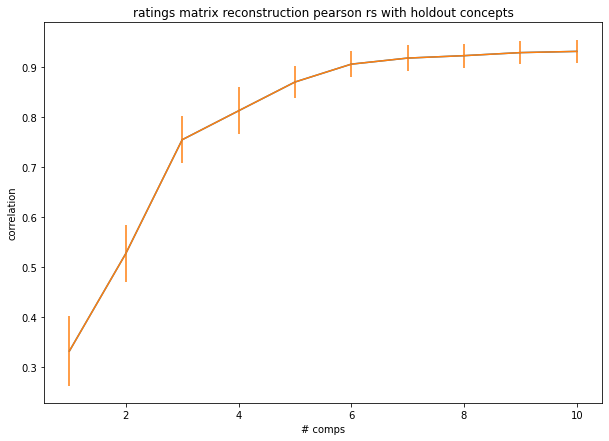

In [59]:
plot_ys = holdout_con_cors.groupby('num_pc').mean().reset_index().holdout_cor
plot_err = holdout_con_cors.groupby('num_pc').std().reset_index().holdout_cor/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(1,11),plot_ys)
plt.errorbar(x= np.arange(1,11),y = plot_ys,yerr=plot_err)
plt.title('ratings matrix reconstruction pearson rs with holdout concepts')
plt.xlabel('# comps')
plt.ylabel('correlation')

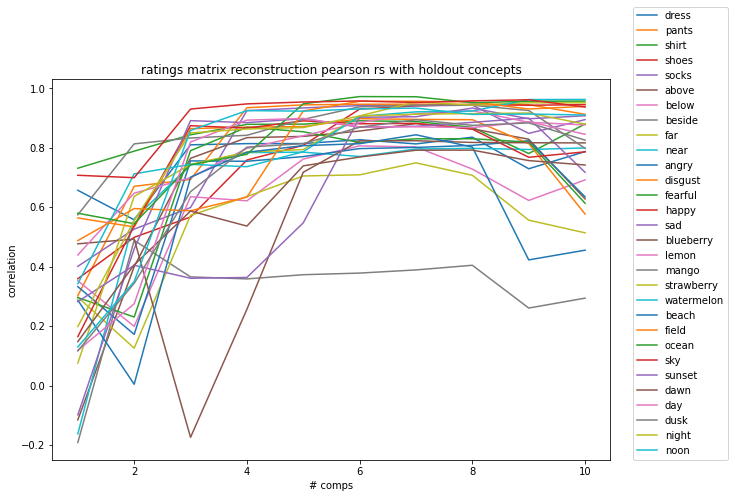

In [38]:
plt.figure(figsize=(10,7))
for this_concept in concept_list:
    plot_ys = holdout_con_cors[holdout_con_cors.concept==this_concept].holdout_cor
    plt.plot(np.arange(1,11),plot_ys, label=this_concept)
    plt.title('ratings matrix reconstruction pearson rs with holdout concepts')
    plt.xlabel('# comps')
    plt.ylabel('correlation')
    plt.legend(loc=(1.04,0))
plt.show()

In [39]:
plot_ys

29     0.129760
59     0.349714
89     0.857713
119    0.924396
149    0.922548
179    0.929954
209    0.932932
239    0.911638
269    0.912785
299    0.909621
Name: holdout_cor, dtype: float64

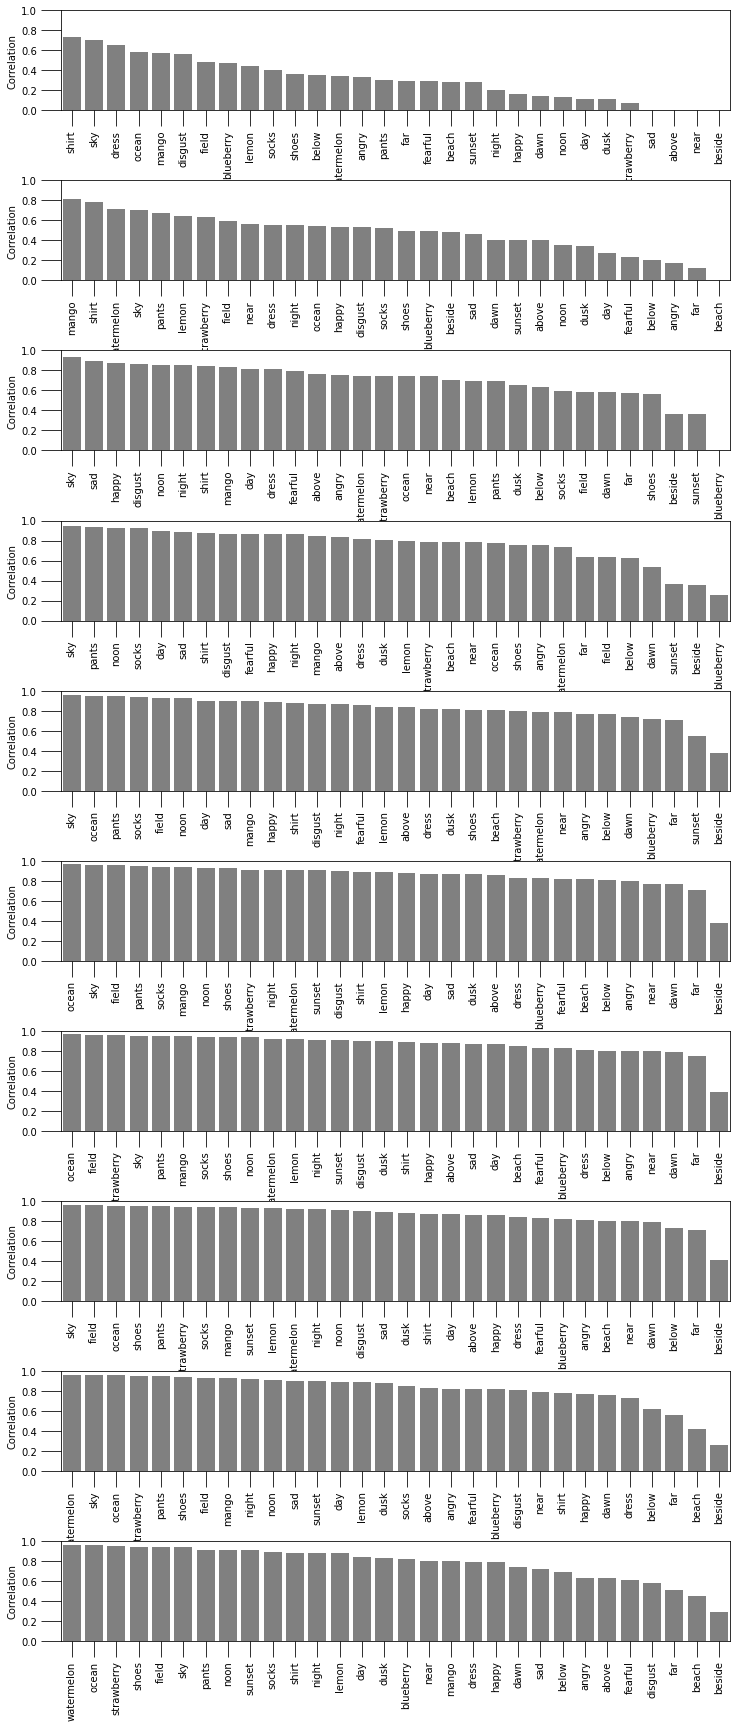

In [40]:

fig, ax = plt.subplots(10,1, figsize=(12,30))

fig.subplots_adjust(hspace=.7)

for i in range(1,11):
    concept_holdout = holdout_con_cors[holdout_con_cors.num_pc==i]

    concept_holdout = concept_holdout.sort_values(['holdout_cor'],ascending=False).reset_index(drop=True)

    sns.barplot(ax=ax[i-1],x= concept_holdout.concept, y= concept_holdout.holdout_cor, edgecolor = 'none', color='gray')
    #plt.axis('off')
    #plt.xticks([])
    #x[i].xticks(rotation = 90, fontsize= 16)
    ax[i-1].tick_params(axis='x',labelrotation=90, size=16)
    ax[i-1].set_xlabel('')
    ax[i-1].tick_params(axis='y', size=20)
    ax[i-1].set_ylabel('Correlation')
    ax[i-1].set_ylim(0,1)
    #ax = plt.gca()
    #ax.set_facecolor((0.3497,0.3497,0.3497))
    ax[i-1].set_facecolor((1,1,1))
    #plt.title("Reconstruction correlations while leaving out one concept at a time")
    # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
    # plt.show()

In [41]:
# concept_holdout = concept_holdout.sort_values(['correlation'],ascending=False).reset_index(drop=True)
# fig = plt.figure(figsize=(10,7))
# sns.barplot(concept_holdout.concept, concept_holdout.correlation, edgecolor = 'none', color='gray')
# #plt.axis('off')
# #plt.xticks([])
# plt.xticks(rotation = 90, fontsize= 16)
# plt.xlabel('')
# plt.yticks(fontsize=18)
# plt.ylabel('Correlation', fontsize=20)
# plt.ylim(0,1)
# ax = plt.gca()
# #ax.set_facecolor((0.3497,0.3497,0.3497))
# ax.set_facecolor((1,1,1))
# plt.title("Reconstruction correlations while leaving out one concept at a time")
# # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
# # plt.show()

In [42]:
# np.mean(cors)

## Color generalization

In [101]:
assoc_mat = np.array(pd.read_csv('../../data/uw_58_ratings_matrix_unscaled.csv'))[:,1:]
assoc_mat = assoc_mat.astype('float')
assoc_mat_c = assoc_mat- c_means.V1.values
U,S,Vh = svd(assoc_mat_c, full_matrices=False)
v_sub = Vh[0:10,]
conc_prof_mat= U @ np.diag(S) ### actual ground truth factor matrix


component 1 when there are 10 components: 0.9259460041177533
component 2 when there are 10 components: 0.9018020649712754
component 3 when there are 10 components: 0.9463378253382649
component 4 when there are 10 components: 0.8649298463474977
component 5 when there are 10 components: 0.9336072185613258
component 6 when there are 10 components: 0.7069474367733067
component 7 when there are 10 components: 0.5726708010202106
component 8 when there are 10 components: 0.2792722245518209
component 9 when there are 10 components: 0.6186250127417133
component 10 when there are 10 components: 0.20145925501642908


Text(0, 0.5, 'correlation')

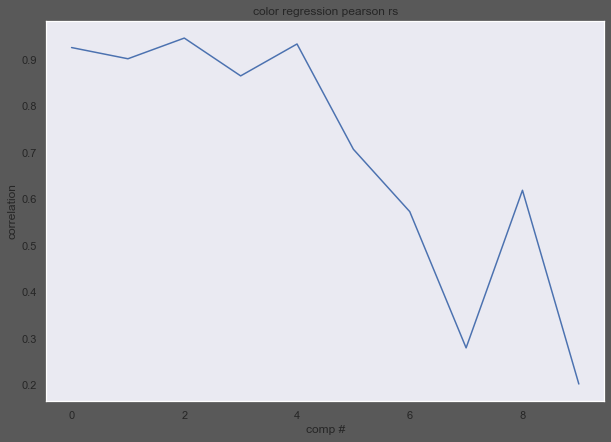

In [102]:
prof_coef_mat = pd.read_csv(f'../../data/10_regression_weights.csv', header=None).to_numpy()
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
col_prof_cors = [] ## correlations between profiles predicted from colorimetric coordinates and right singualr vectors
for i in range(10):   
    print(f'component {i+1} when there are {10} components: {np.corrcoef(np.matmul(prof_coef_mat.T,color_coord_mat)[i,:],Vh[i,:])[0][1]}')
    col_prof_cors.append(np.corrcoef(np.matmul(prof_coef_mat.T,color_coord_mat)[i,:],Vh[i,:])[0][1])

fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(10),col_prof_cors)
plt.title('color regression pearson rs')
plt.xlabel('comp #')
plt.ylabel('correlation')


In [103]:
num_pcs =[]
cors = []
col_reg_cors = []
for num_pc in range(10):

    prof_coef_mat = pd.read_csv(f'../../data/{num_pc+1}_regression_weights.csv', header=None).to_numpy()
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()

    recon = np.matmul(conc_prof_mat[:,:(num_pc+1)],np.matmul((prof_coef_mat.T)[:(num_pc+1),],color_coord_mat)).T
    recon = recon+c_means.V1.values.reshape(58,1)
    recon = recon.T
 
    for i in range(58):
        cors.append(np.corrcoef(recon[:,i], assoc_mat[:,i])[0,1])
        num_pcs.append(num_pc+1)




In [104]:
no_holdout_colcors = pd.DataFrame(list(zip(num_pcs,list(range(1,59))*10,cors)), columns = ['num_pcs','color','correlation'])

Text(0, 0.5, 'correlation')

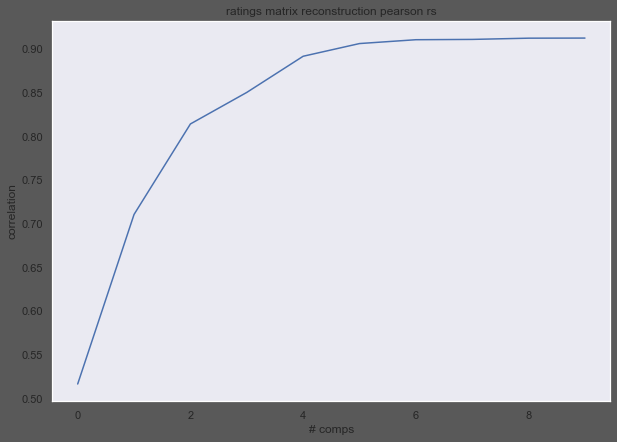

In [105]:
plot_ys = no_holdout_colcors.groupby('num_pcs').mean().reset_index().correlation
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(10),plot_ys)
plt.title('ratings matrix reconstruction pearson rs')
plt.xlabel('# comps')
plt.ylabel('correlation')

<BarContainer object of 30 artists>

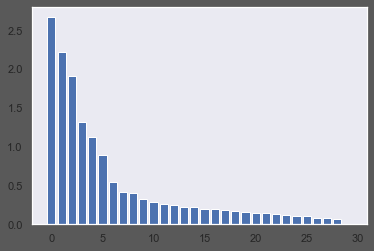

In [106]:
plt.bar(np.arange(30),S)

In [107]:
# cors= []

# conc_prof_mat_C = np.zeros(shape = (30,8))

# ratings.loc[:, ratings.columns != 'V'+str(51)]
# for this_color in range(1,59):
#     for i in range(ratings.shape[0]):
#         column_name = 'V'+str(this_color)
#         ratings_sub = ratings.loc[:, ratings.columns != column_name]
#         ratings_sub = ratings_sub.iloc[:,1:]
#         concept_ratings = np.array(ratings_sub)-c_means[c_means.iloc[:,0]!=this_color].V1.values
#         A = pd.read_csv('../../data/basis_vecs_scaled_color_{}.csv'.format(this_color))
#         A = np.array(A)
#         A = np.delete(A, 0, axis=1)
#         A_8 = A[:,0:8]
        
#         reg = lm.LinearRegression().fit(A_8, concept_ratings.T)
#         coords = reg.coef_[0:8]
#         recon = np.matmul(A_8,coords)

    #cors.append(np.corrcoef(recon.astype(float),concept_ratings.squeeze(0).astype(float))[0,1])

    

In [108]:
### So here we're holding out one color at a time and trying to estimate concept ratings for each of the holdouts



# conc_prof_mats = []
# for this_color in range(1,59):
#     conc_prof_mat_C = np.zeros(shape=(30,5))
#     A = pd.read_csv('../../data/basis_vecs_scaled_color_{}.csv'.format(this_color))
#     A = np.array(A)
#     #A_8 = A[:,0:8]
#     for i in range(ratings.shape[0]):
        
#         column_name = 'V'+str(this_color)
#         concept_ratings = ratings.loc[:,ratings.columns != column_name]
#         concept_ratings = concept_ratings.iloc[i][1:]
#         concept_ratings = np.array(concept_ratings)
#         concept_ratings = concept_ratings-c_means[c_means.index!=(this_color-1)].V1.values
        
        
#         reg = lm.LinearRegression().fit(A[:,:5], concept_ratings)
#         coords = reg.coef_[0:5]
#         recon = np.matmul(A[:,:5],coords)
#         conc_prof_mat_C[i,:] = coords
#     #conc_prof_mats.append(conc_prof_mat_C)
    


In [109]:
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
cors = []
for i in range(1,59):
    ratings_sub = ratings.iloc[:,1:] ## removing label column
    ratings_sub = ratings_sub.iloc[:,i-1] ## selecting column of holdout color
    
    #this_conc_prof_mat = conc_prof_mats[i-1]
    #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
    this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:5]
    this_prof_coef_mat = pd.read_csv('../../data/8_regression_weights_color_{}.csv'.format(i), header=None).to_numpy()[:,:5]
    recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+c_means.V1.values
    cors.append(np.corrcoef(recon[:,i-1],ratings_sub)[0,1])
    

In [110]:
colcors = pd.DataFrame(list(zip(list(range(1,59)),cors)), columns = ['color','holdout_correlation'])
uw58rgb = pd.read_csv('../../data/UW_58_rgb.csv', header=None)
colcors = pd.concat([colcors, uw58rgb], axis=1)
colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)

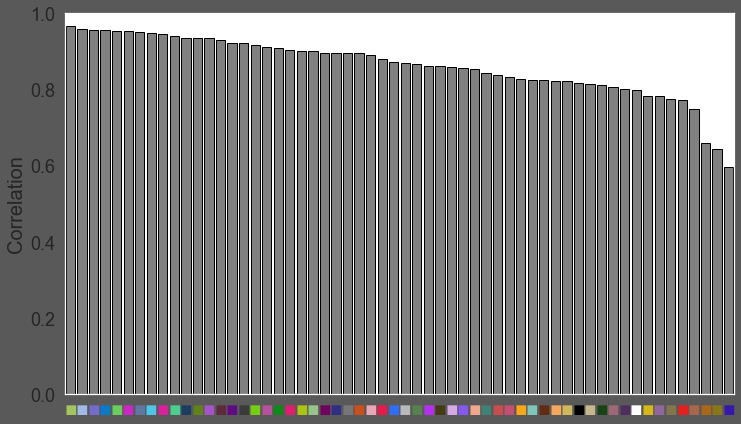

In [111]:
import matplotlib.font_manager as mfm

font_path = 'FreeSerif.ttf'
prop = mfm.FontProperties(fname=font_path)


#colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(12,7))
sns.barplot(colcors.index, colcors.holdout_correlation, edgecolor = 'black', color='gray')
#plt.axis('off')
#plt.xticks([])
#plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
symbolsx = [u"■"]*colcors.shape[0]
ax.set_xticks(range(len(symbolsx)))
ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors[0],colcors[1],colcors[2])))):
    tick.set_color(color)

#plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()


In [112]:
np.mean(cors)

0.8630759214904336

## Let's vary both num pc and the holdout

In [113]:
num_pcs =[]
cors = []
col_reg_cors = []
col_num = []
for num_pc in range(9):

    prof_coef_mat = pd.read_csv(f'../../data/{num_pc+1}_regression_weights.csv', header=None).to_numpy()
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()

    recon = np.matmul(conc_prof_mat[:,:(num_pc+1)],np.matmul((prof_coef_mat.T)[:(num_pc+1),],color_coord_mat)).T
    recon = recon+c_means.V1.values.reshape(58,1)
    recon = recon.T
 
    for i in range(1,59):
        ratings_sub = ratings.iloc[:,1:] ## removing label column
        ratings_sub = ratings_sub.iloc[:,i-1] ## selecting column of holdout color
        
        #this_conc_prof_mat = conc_prof_mats[i-1]
        #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
        this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:num_pc]
        this_prof_coef_mat = pd.read_csv('../../data/8_regression_weights_color_{}.csv'.format(i), header=None).to_numpy()[:,:num_pc]
        recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+c_means.V1.values
        cors.append(np.corrcoef(recon[:,i-1],ratings_sub)[0,1])
        num_pcs.append(num_pc+1)
        col_num.append(i)



In [114]:
holdout_col_cors= pd.DataFrame(list(zip(cors,num_pcs,col_num)), columns=['correlation','#_pc','holdout_col'])

Text(0, 0.5, 'correlation')

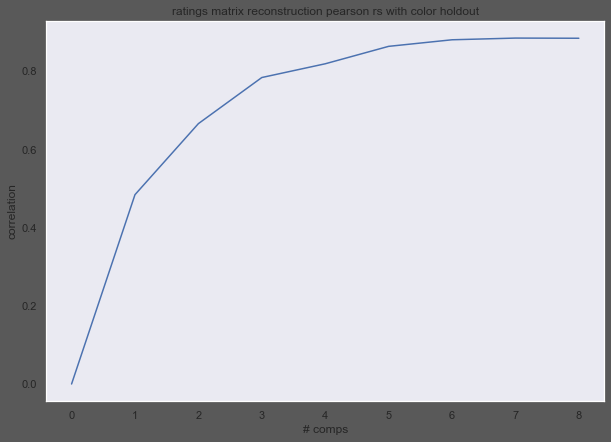

In [115]:
plot_ys = holdout_col_cors.groupby('#_pc').mean().reset_index().correlation
plt.figure(figsize=(10,7))
plt.plot(np.arange(9),plot_ys)
plt.title('ratings matrix reconstruction pearson rs with color holdout')
plt.xlabel('# comps')
plt.ylabel('correlation')

In [116]:
uw58map = sns.color_palette(list(zip(uw58rgb[0],uw58rgb[1],uw58rgb[2])))

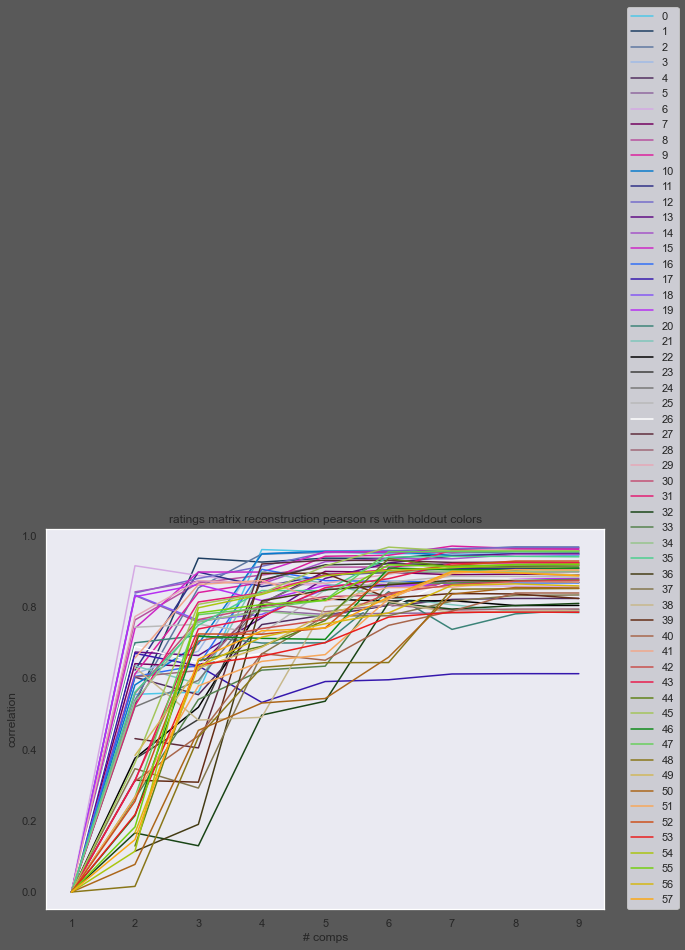

In [117]:
plt.figure(figsize=(10,7))
for i in range(58):
    plot_ys = holdout_col_cors[holdout_col_cors.holdout_col==i+1].correlation
    plt.plot(np.arange(1,10),plot_ys, label=i, color=uw58map[i])
    plt.title('ratings matrix reconstruction pearson rs with holdout colors')
    plt.xlabel('# comps')
    plt.ylabel('correlation')
    plt.legend(loc=(1.04,0))
plt.show()

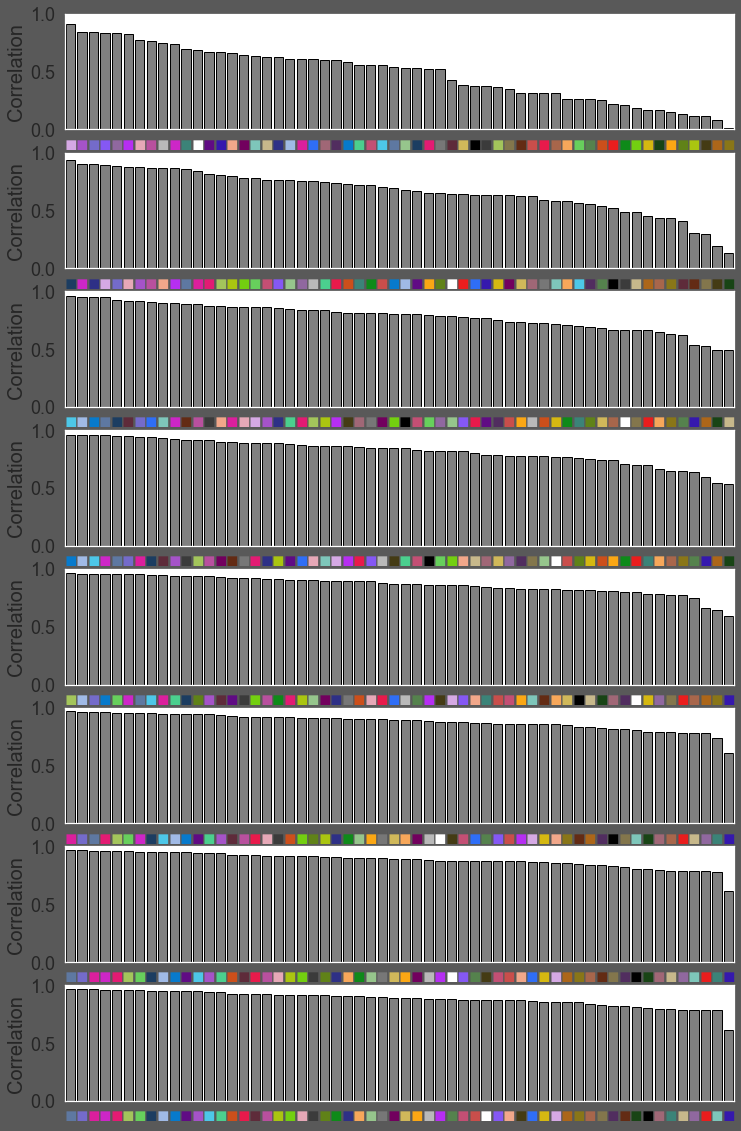

In [118]:

fig, ax = plt.subplots(8,1, figsize=(12,20))

for i in range(2,10):
    

    colcors = holdout_col_cors[holdout_col_cors['#_pc']==i].reset_index(drop=True)
    uw58rgb = pd.read_csv('../../data/UW_58_rgb.csv', header=None)
    colcors = pd.concat([colcors, uw58rgb], axis=1)
    colcors = colcors.sort_values(['correlation'],ascending=False).reset_index(drop=True)


    sns.barplot(ax=ax[i-2],x= colcors.index, y= colcors.correlation, edgecolor = 'black', color='gray')
    #plt.axis('off')
    #plt.xticks([])
    #plt.xticks(rotation = 90, fontsize= 16)
    ax[i-2].set_xlabel('')
    ax[i-2].tick_params(axis='y',labelsize=18)
    ax[i-2].set_ylabel('Correlation', fontsize=20)
    ax[i-2].set_ylim(0,1)
    #ax = plt.gca()
    #ax.set_facecolor((0.3497,0.3497,0.3497))
    ax[i-2].set_facecolor((1,1,1))
    symbolsx = [u"■"]*colcors.shape[0]
    ax[i-2].set_xticks(range(len(symbolsx)))
    ax[i-2].set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
    for tick, color in zip(ax[i-2].get_xticklabels(), sns.color_palette(list(zip(colcors[0],colcors[1],colcors[2])))):
        tick.set_color(color)

    #plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
    #plt.show()


In [119]:
ax[2]

<AxesSubplot:ylabel='Correlation'>

In [120]:
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
cors = []
for i in range(1,59):
    ratings_sub = ratings.iloc[:,1:] ## removing label column
    ratings_sub = ratings_sub.iloc[:,i-1] ## selecting column of holdout color
    
    #this_conc_prof_mat = conc_prof_mats[i-1]
    #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
    this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:5]
    this_prof_coef_mat = pd.read_csv('../../data/8_regression_weights_color_{}.csv'.format(i), header=None).to_numpy()[:,:5]
    recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+c_means.V1.values
    cors.append(np.corrcoef(recon[:,i-1],ratings_sub)[0,1])
    

In [100]:
v_sub.shape

(5, 58)

## Plotting Profiles

In [121]:
v_sub_df = pd.DataFrame(v_sub.T, columns=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'])
v_sub_df = pd.concat([v_sub_df, uw58rgb],axis=1)





In [122]:
components

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

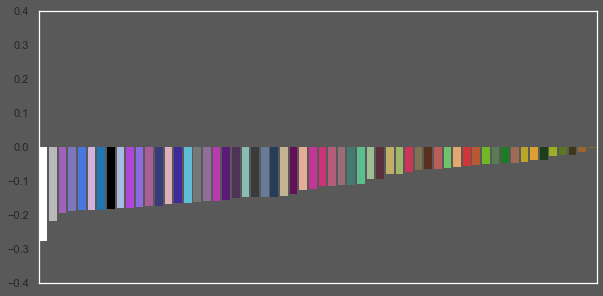

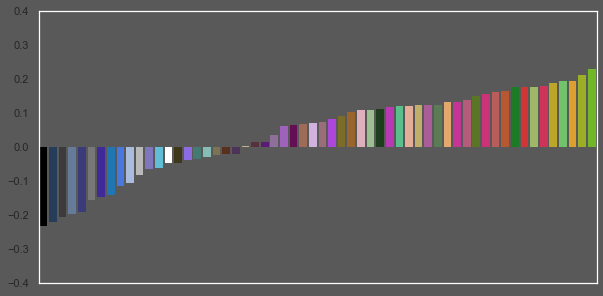

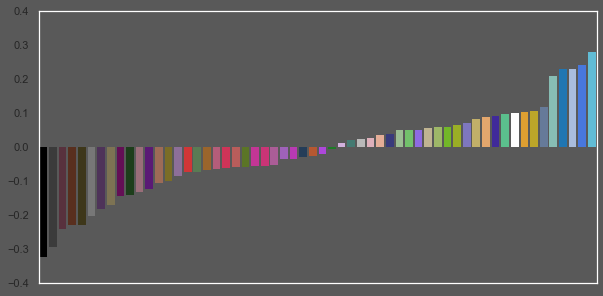

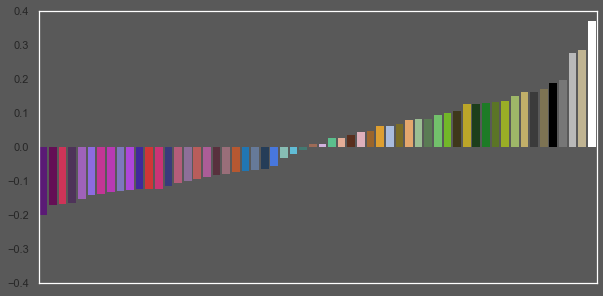

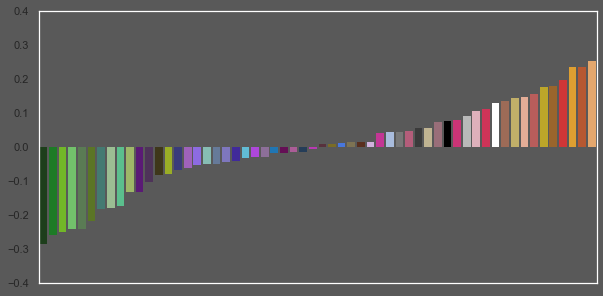

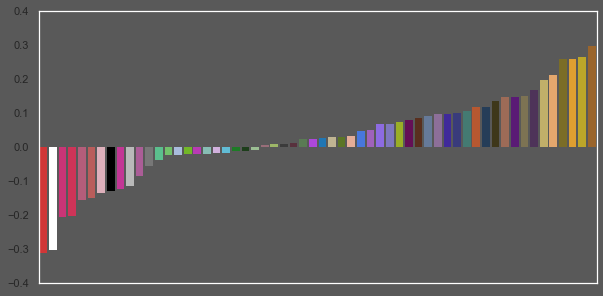

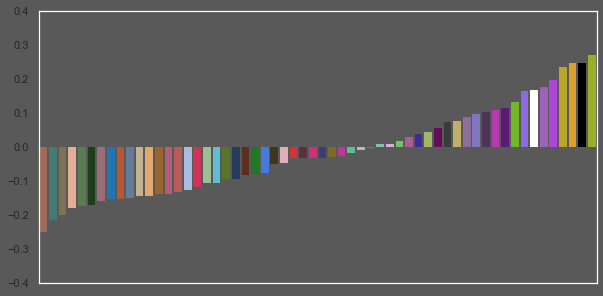

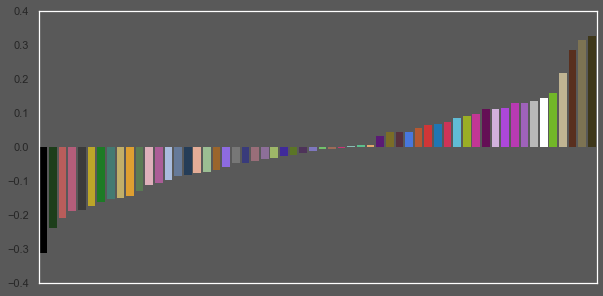

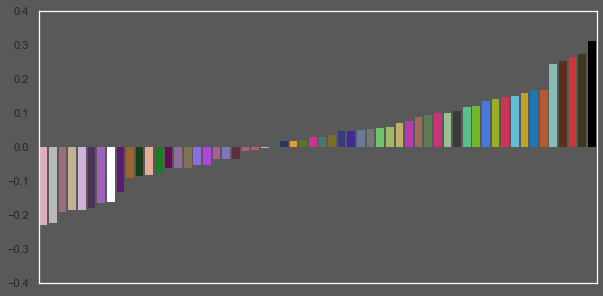

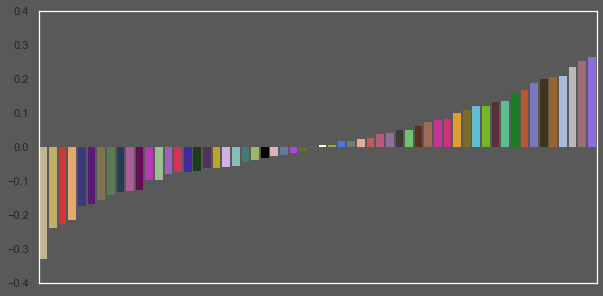

In [123]:
components = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

for i in range(len(components)):
    sns.set(rc={'figure.facecolor':(0.3497,0.3497,0.3497),
               'axes.grid':False})
    plt.figure(figsize=(10,5))


    plotdf = v_sub_df.sort_values([str(components[i])]).reset_index(drop=True)
    fig = sns.barplot(plotdf.index, plotdf[components[i]], edgecolor = 'none',palette = sns.color_palette(list(zip(plotdf[0],plotdf[1],plotdf[2]))))
    #plt.axis('off')
    plt.xticks([])
    plt.ylabel('')
    plt.ylim(-0.4,0.4)
    ax = plt.gca()
    ax.set_facecolor((0.3497,0.3497,0.3497))
    
    plt.savefig('component_{}.pdf'.format(i))
    plt.show()
    

In [97]:
#Reconstructed ratings from matlab

In [123]:
reg_preds= pd.read_csv('../../data/regression_predictions.csv',header=None)
reg_preds = np.array(reg_preds)[:5,:]
reg_preds_df = pd.DataFrame(reg_preds.T, columns=['C1','C2','C3','C4','C5'])
reg_preds_df = pd.concat([reg_preds_df, uw58rgb],axis=1)

In [ ]:


for i in range(len(components)):
    sns.set(rc={'figure.facecolor':(0.3497,0.3497,0.3497),
               'axes.grid':False})
    plt.figure(figsize=(10,5))


    plotdf = reg_preds_df.sort_values([str(components[i])]).reset_index(drop=True)
    fig = sns.barplot(plotdf.index, plotdf[components[i]], edgecolor = 'none',palette = sns.color_palette(list(zip(plotdf[0],plotdf[1],plotdf[2]))))
    #plt.axis('off')
    plt.xticks([])
    plt.ylabel('')
    plt.ylim(-0.4,0.4)
    ax = plt.gca()
    ax.set_facecolor((0.3497,0.3497,0.3497))
    
    plt.savefig('pred_component_{}.pdf'.format(i))
    plt.show()

In [ ]:
color_reg_cors=[]
for i in range(8):
    color_reg_cors.append(np.corrcoef(v_sub[i,:],reg_preds[i,:])[0,1])
color_reg_cors

In [ ]:
#fig = plt.figure()
sns.set(rc={'figure.facecolor':(1,1,1),
               'axes.grid':False})
fig = sns.palplot(uw58rgb.to_numpy())
#fig.get_figure()
#fig.savefig('uw58pal.pdf')

In [ ]:
fig

In [ ]:
U_concepts = [ "dress"  ,    "pants" ,     "shirt"   ,   "shoes"  ,    "socks"   ,   "above"  ,    "below"   ,   "beside"  ,  
"far"     ,   "near"    ,   "angry"    ,  "disgust"  ,  "fearful" ,   "happy"   ,   "sad"  ,      "blueberry" ,
 "lemon"    ,  "mango"  ,    "strawberry" ,"watermelon" ,"beach"   ,   "field"   ,   "ocean"   ,   "sky" ,      
 "sunset"  ,   "dawn"  ,     "day"   ,     "dusk"  ,     "night"    ,  "noon"]       

In [ ]:
for i in range(U.shape[0]):
    print(U[i,0:8])

In [ ]:

    
U_ratings = U[:,0:8]

U_ratings = U_ratings - U_ratings.mean(axis=0)
U_ratings = U_ratings / np.abs(U_ratings).max(axis=0)



In [ ]:
U_ratings_df = pd.DataFrame(U_ratings)

In [ ]:
U_ratings_df['concept']= U_concepts

In [ ]:
from numpy import eye, asarray, dot, sum, diagx
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [ ]:
sns.color_palette(list(zip(colcors[0],colcors[1],colcors[2])))

### Generalization

In [110]:
### read in new dataset
uw71coords = pd.read_csv('../../data/uw71coords.csv').sort_values(by= 'uw71touw58')
gen_df = pd.read_csv('../../data/generalization_data.csv')

In [134]:
## pick colors

color_inds = return_rows(ratings.iloc[:,1:]-c_means.V1.values,14)

In [111]:
np.cos(0.0174533*uw71coords.H[10]*2)

-0.10454088147834097

In [112]:
color_coord_mat[,]

SyntaxError: invalid syntax (798019071.py, line 1)

In [113]:
color_coord_mat_gen = np.ones((7,71))

In [117]:
color_coord_mat_gen[2,:] = np.cos(0.0174533*uw71coords.H)
color_coord_mat_gen[3,:] = np.sin(0.0174533*uw71coords.H)
color_coord_mat_gen[4,:] = np.cos(2*0.0174533*uw71coords.H)
color_coord_mat_gen[5,:] = np.sin(2*0.0174533*uw71coords.H)
color_coord_mat_gen[1,:] = (uw71coords.L)
color_coord_mat_gen[6,:] = (uw71coords.C)

In [143]:
c_means_gen =gen_df.iloc[:,1:].mean(axis=0)


,Unnamed: 0,v_index,color_index,L,a,b,C,H,r_rgb,g_rgb,b_rgb,r255,g255,b255,color_hex,uw71touw58
10,10,V11,10,75,-23.6570,-26.274,35.355010,228.000260,0.30294,0.78057,0.90983,77.24970,199.04535,232.00665,#4dc7e8,0.0
11,11,V12,11,25,1.3084,-24.966,25.000261,272.999971,0.11078,0.23798,0.38006,28.24890,60.68490,96.91530,#1c3d61,1.0
12,12,V13,12,50,1.3084,-24.966,25.000261,272.999971,0.36676,0.47151,0.63164,93.52380,120.23505,161.06820,#5e78a1,2.0
13,13,V14,13,75,1.3084,-24.966,25.000261,272.999971,0.62755,0.72906,0.90271,160.02525,185.91030,230.19105,#a0bae6,3.0
14,14,V15,14,25,26.2740,-23.657,35.355010,318.000260,0.31571,0.17533,0.37401,80.50605,44.70915,95.37255,#512d5f,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,V59,58,88,-2.6168,49.931,49.999524,93.000031,0.96685,0.86069,0.48682,246.54675,219.47595,124.13910,#f7db7c,NaN
63,63,V64,63,88,-78.8220,70.972,106.065699,137.999858,0.24405,0.99448,0.26544,62.23275,253.59240,67.68720,#3efe44,NaN
65,65,V66,65,88,-53.8570,72.280,90.138642,126.690393,0.60202,0.95780,0.26090,153.51510,244.23900,66.52950,#9af443,NaN
67,67,V68,67,88,-28.8910,73.589,79.057136,111.434944,0.81500,0.91380,0.25817,207.82500,233.01900,65.83335,#d0e942,NaN


In [221]:
num_cols =[]
approx_cors = []
cons = []

conc_prof_mat = np.zeros(shape=(20,6)) ## this matrix holds the approximated factor matrix 
    # color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix

prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors

approx_basis_vecs = prof_coef_mat.T@color_coord_mat_gen

for i in range(gen_df.shape[0]): ## iterate through each concept
    

    concept_ratings = gen_df.iloc[i][1:]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-c_means_gen.values
    reg = lm.LinearRegression().fit(basis_vecs[color_inds,0:6], concept_ratings[color_inds])
    #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
    coords = reg.coef_[0:6]   ## only use num_pc components
    # recon = np.matmul(A[:,:num_pc],coords)
    # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
    conc_prof_mat[i,:] = coords
    

## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)

approx_recon = conc_prof_mat@approx_basis_vecs 


for i in range(approx_recon.shape[0]):
    concept_ratings = gen_df.iloc[i][1:]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-c_means_gen.values
    approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
    cons.append(gen_df.iloc[i][0])


approx_df = pd.DataFrame(list(zip(cons,approx_cors)), columns = ['concept','correlation'])

In [222]:
approx_recon.shape

(20, 71)

In [223]:
uw71coords

,Unnamed: 0,v_index,color_index,L,a,b,C,H,r_rgb,g_rgb,b_rgb,r255,g255,b255,color_hex,uw71touw58
10,10,V11,10,75,-23.6570,-26.274,35.355010,228.000260,0.30294,0.78057,0.90983,77.24970,199.04535,232.00665,#4dc7e8,0.0
11,11,V12,11,25,1.3084,-24.966,25.000261,272.999971,0.11078,0.23798,0.38006,28.24890,60.68490,96.91530,#1c3d61,1.0
12,12,V13,12,50,1.3084,-24.966,25.000261,272.999971,0.36676,0.47151,0.63164,93.52380,120.23505,161.06820,#5e78a1,2.0
13,13,V14,13,75,1.3084,-24.966,25.000261,272.999971,0.62755,0.72906,0.90271,160.02525,185.91030,230.19105,#a0bae6,3.0
14,14,V15,14,25,26.2740,-23.657,35.355010,318.000260,0.31571,0.17533,0.37401,80.50605,44.70915,95.37255,#512d5f,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,V59,58,88,-2.6168,49.931,49.999524,93.000031,0.96685,0.86069,0.48682,246.54675,219.47595,124.13910,#f7db7c,NaN
63,63,V64,63,88,-78.8220,70.972,106.065699,137.999858,0.24405,0.99448,0.26544,62.23275,253.59240,67.68720,#3efe44,NaN
65,65,V66,65,88,-53.8570,72.280,90.138642,126.690393,0.60202,0.95780,0.26090,153.51510,244.23900,66.52950,#9af443,NaN
67,67,V68,67,88,-28.8910,73.589,79.057136,111.434944,0.81500,0.91380,0.25817,207.82500,233.01900,65.83335,#d0e942,NaN


In [224]:
approx_df

,concept,correlation
0,bear,0.830945
1,bird,0.576579
2,fish,0.752435
3,frog,0.887282
4,lion,0.883377
5,airplane,0.715817
6,boat,0.765239
7,car,0.344478
8,plane,0.729778
9,truck,0.564256


In [225]:
approx_df.correlation.mean()

0.7408114666205422

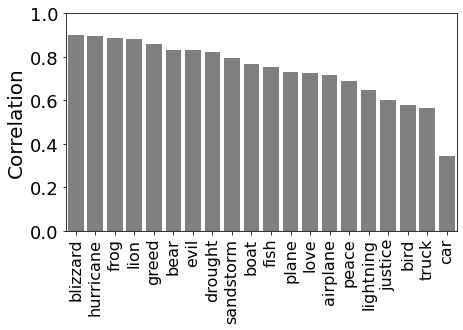

In [226]:

approx_df_sub = approx_df.sort_values(['correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(7,4))
sns.barplot(approx_df_sub.concept, approx_df_sub.correlation, edgecolor = 'none', color='gray')
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
#plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} colors")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()

In [227]:
color_inds

[4, 21, 22, 23, 24, 26, 32, 38, 49, 50, 53, 54, 56, 57]

In [228]:
sns.color_palette(uw58rgb_tups[return_rows(ratings.iloc[:,1:]-c_means.V1.values,14)])

[(0.31571, 0.17533, 0.37401),
 (0.49553, 0.7754, 0.73022),
 (0.0, 0.0, 0.0),
 (0.23251, 0.23251, 0.23251),
 (0.46633, 0.46633, 0.46633),
 (1.0, 1.0, 1.0),
 (0.093053, 0.26787, 0.081612),
 (0.78226, 0.72092, 0.54415),
 (0.81654, 0.7198, 0.35358),
 (0.67414, 0.40164, 0.098965),
 (0.91683, 0.11258, 0.11559),
 (0.66567, 0.77075, 0.06092),
 (0.83409, 0.72019, 0.066708),
 (0.9829, 0.65643, 0.078187)]

[(0.18536, 0.43139, 0.96497),
 (0.20878, 0.093277, 0.67755),
 (0.52107, 0.34328, 0.95741),
 (0.71554, 0.18209, 0.95015),
 (0.02815, 0.47995, 0.80007),
 (0.17927, 0.18835, 0.5261),
 (0.45531, 0.41794, 0.79284),
 (0.37742, 0.042633, 0.5195),
 (0.64719, 0.32647, 0.78598),
 (0.80294, 0.14735, 0.7795),
 (0.30294, 0.78057, 0.90983),
 (0.11078, 0.23798, 0.38006),
 (0.36676, 0.47151, 0.63164),
 (0.62755, 0.72906, 0.90271),
 (0.31571, 0.17533, 0.37401),
 (0.56583, 0.4087, 0.62522),
 (0.83493, 0.66423, 0.89597),
 (0.44844, 0.0010157, 0.36856),
 (0.72068, 0.31508, 0.61928),
 (0.85795, 0.12084, 0.61389),
 (0.22415, 0.96405, 0.87881),
 (0.23228, 0.51203, 0.47224),
 (0.49553, 0.7754, 0.73022),
 (0.63541, 0.91934, 0.87189),
 (0.0, 0.0, 0.0),
 (0.23251, 0.23251, 0.23251),
 (0.46633, 0.46633, 0.46633),
 (0.7239, 0.7239, 0.7239),
 (1.0, 1.0, 1.0),
 (0.86539, 0.86539, 0.86539),
 (0.36814, 0.16901, 0.22803),
 (0.62657, 0.4033, 0.46106),
 (0.90215, 0.65899, 0.71809),
 (0.76433, 0.30881, 0.45651),
 (0.89143, 0.10584, 0.45276),
 (0.29264, 0.81366, 0.55522),
 (0.45168, 0.96053, 0.69143),
 (0.093053, 0.26787, 0.081612),
 (0.33427, 0.50935, 0.30369),
 (0.58834, 0.77224, 0.54935),
 (0.72747, 0.91598, 0.68535),
 (0.26859, 0.23099, 0.078708),
 (0.51566, 0.46391, 0.29927),
 (0.78226, 0.72092, 0.54415),
 (0.92752, 0.86218, 0.67984),
 (0.38773, 0.16814, 0.078494),
 (0.65938, 0.40118, 0.29597),
 (0.94491, 0.65619, 0.53969),
 (0.78826, 0.307, 0.2939),
 (0.90961, 0.10388, 0.29318),
 (0.054615, 0.54224, 0.099689),
 (0.40222, 0.81194, 0.36144),
 (0.54989, 0.95852, 0.49572),
 (0.37476, 0.50866, 0.096059),
 (0.63947, 0.77079, 0.35693),
 (0.78297, 0.91421, 0.49082),
 (0.53807, 0.4637, 0.095726),
 (0.81654, 0.7198, 0.35358),
 (0.96685, 0.86069, 0.48682),
 (0.67414, 0.40164, 0.098965),
 (0.97029, 0.65547, 0.35149),
 (0.79852, 0.30871, 0.10571),
 (0.91683, 0.11258, 0.11559),
 (0.24405, 0.99448, 0.26544),
 (0.45104, 0.81154, 0.061681),
 (0.60202, 0.9578, 0.2609),
 (0.66567, 0.77075, 0.06092),
 (0.815, 0.9138, 0.25817),
 (0.83409, 0.72019, 0.066708),
 (0.98973, 0.86065, 0.25739),
 (0.9829, 0.65643, 0.078187)]

,Unnamed: 0,v_index,color_index,L,a,b,C,H,r_rgb,g_rgb,b_rgb,r255,g255,b255,color_hex,uw71touw58
10,10,V11,10,75,-23.6570,-26.274,35.355010,228.000260,0.30294,0.78057,0.90983,77.24970,199.04535,232.00665,#4dc7e8,0.0
11,11,V12,11,25,1.3084,-24.966,25.000261,272.999971,0.11078,0.23798,0.38006,28.24890,60.68490,96.91530,#1c3d61,1.0
12,12,V13,12,50,1.3084,-24.966,25.000261,272.999971,0.36676,0.47151,0.63164,93.52380,120.23505,161.06820,#5e78a1,2.0
13,13,V14,13,75,1.3084,-24.966,25.000261,272.999971,0.62755,0.72906,0.90271,160.02525,185.91030,230.19105,#a0bae6,3.0
14,14,V15,14,25,26.2740,-23.657,35.355010,318.000260,0.31571,0.17533,0.37401,80.50605,44.70915,95.37255,#512d5f,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,V59,58,88,-2.6168,49.931,49.999524,93.000031,0.96685,0.86069,0.48682,246.54675,219.47595,124.13910,#f7db7c,NaN
63,63,V64,63,88,-78.8220,70.972,106.065699,137.999858,0.24405,0.99448,0.26544,62.23275,253.59240,67.68720,#3efe44,NaN
65,65,V66,65,88,-53.8570,72.280,90.138642,126.690393,0.60202,0.95780,0.26090,153.51510,244.23900,66.52950,#9af443,NaN
67,67,V68,67,88,-28.8910,73.589,79.057136,111.434944,0.81500,0.91380,0.25817,207.82500,233.01900,65.83335,#d0e942,NaN


In [256]:

cors = []
for i in range(58,71):
    ratings_sub = gen_df.iloc[:,i]

    
    #this_conc_prof_mat = conc_prof_mats[i-1]
    #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
    #factor = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:5]
    prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6]

    recon = conc_prof_mat@prof_coef_mat.T@color_coord_mat_gen[:,i]
    cors.append(np.corrcoef(recon,ratings_sub)[0,1])
    

In [257]:
cors

[-0.2718545334709354,
 0.783151606507016,
 0.41059799270807645,
 0.2472119838571729,
 0.571953342506568,
 0.16248420463648933,
 0.18517756752861056,
 0.33240742153949715,
 0.2511744429847125,
 0.23012482788557642,
 0.3156761465829641,
 0.17289421115582257,
 0.3024792325484886]

In [277]:
uw71_tups = np.array(uw71coords.sort_values(by='color_index').apply(lambda x: tuple([x['r_rgb'],x['g_rgb'],x['b_rgb']]),axis=1))

sns.color_palette(uw71_tups[[int(i) for i in list(gen_df.columns[59:])]])

[(0.22415, 0.96405, 0.87881),
 (0.63541, 0.91934, 0.87189),
 (0.86539, 0.86539, 0.86539),
 (0.45168, 0.96053, 0.69143),
 (0.72747, 0.91598, 0.68535),
 (0.92752, 0.86218, 0.67984),
 (0.54989, 0.95852, 0.49572),
 (0.78297, 0.91421, 0.49082),
 (0.96685, 0.86069, 0.48682),
 (0.24405, 0.99448, 0.26544),
 (0.60202, 0.9578, 0.2609),
 (0.815, 0.9138, 0.25817),
 (0.98973, 0.86065, 0.25739)]

array([(0.18536, 0.43139, 0.96497), (0.52107, 0.34328, 0.95741),
       (0.02815, 0.47995, 0.80007), (0.17927, 0.18835, 0.5261)],
      dtype=object)

['20', '23', '29', '36', '40', '44', '52', '55', '58', '63', '65', '67', '69']

13

In [205]:
a@np.diag(b).T@c

array([[ 0.10153053,  0.16127076,  0.12392177, ...,  0.04473394,
         0.11840847,  0.05490221],
       [-0.00070906,  0.20236451,  0.08730719, ..., -0.09094314,
        -0.08247695, -0.08613946],
       [ 0.14043678,  0.19168743,  0.16564052, ...,  0.00707769,
         0.01622097,  0.00636054],
       ...,
       [-0.05083866,  0.0999711 ,  0.06173185, ..., -0.03366722,
         0.00286947, -0.02742943],
       [-0.0911875 ,  0.11107575,  0.01865045, ..., -0.11767885,
        -0.10183984, -0.0959178 ],
       [ 0.15049855, -0.08764518, -0.03007048, ...,  0.15778627,
         0.15362528,  0.15977987]])

In [202]:
c

array([[-0.16486512, -0.14660562, -0.14685527, ..., -0.04960828,
        -0.04393564, -0.03881057],
       [-0.06348882, -0.22023026, -0.19617798, ...,  0.22800683,
         0.1882803 ,  0.19447175],
       [ 0.27853414, -0.02858336,  0.11677332, ...,  0.05835056,
         0.10689605,  0.10136407],
       ...,
       [ 0.07925095, -0.08587089,  0.03448264, ...,  0.0133498 ,
         0.00671341, -0.04128475],
       [ 0.1892563 , -0.06382162,  0.02321681, ...,  0.14805075,
        -0.01853619,  0.10959339],
       [-0.03326036, -0.02835328, -0.10992272, ..., -0.06796566,
        -0.02182108,  0.16089442]])

In [203]:
basis_vecs

array([[-0.16486512, -0.06348882,  0.27853414, ...,  0.07925095,
         0.1892563 ,  0.01848649],
       [-0.14660562, -0.22023026, -0.02858336, ..., -0.08587089,
        -0.06382162,  0.05715453],
       [-0.14685527, -0.19617798,  0.11677332, ...,  0.03448264,
         0.02321681, -0.21525687],
       ...,
       [-0.04960828,  0.22800683,  0.05835056, ...,  0.0133498 ,
         0.14805075, -0.0288487 ],
       [-0.04393564,  0.1882803 ,  0.10689605, ...,  0.00671341,
        -0.01853619,  0.1572486 ],
       [-0.03881057,  0.19447175,  0.10136407, ..., -0.04128475,
         0.10959339,  0.00148151]])